Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D



In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_test = pathlib.Path('/content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Test/')
data_dir_train = pathlib.Path("/content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

##def image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', 
#batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, 
#interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, **kwargs)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='categorical', 
                                                               class_names=None, color_mode='rgb', batch_size=batch_size, 
                                                               image_size=(img_height, img_width), shuffle=True, 
                                                               seed=seed, validation_split=0.2, subset='training', 
                                                               interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='categorical', 
                                                               class_names=None, color_mode='rgb', batch_size=batch_size, 
                                                               image_size=(img_height, img_width), shuffle=True, 
                                                               seed=seed, validation_split=0.2, subset='validation', 
                                                               interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

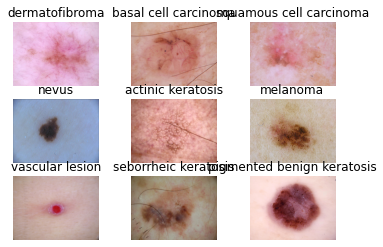

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

num=0
for dirpath, dirnames, filenames in os.walk(str(data_dir_train)):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3,3,num+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        num=num+1


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [12]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
#optimizer='rmsprop', loss=None, metrics=None, loss_weights=None, weighted_metrics=None, run_eagerly=None, steps_per_execution=None, jit_compile=None, **kwargs)

##model.compile(optimizer='your_optimser',
##              loss=your_loss_function_goes_here,
##              metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=[tf.keras.metrics.BinaryAccuracy()])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/20
56/56 [==============================] - 180s 635ms/step - loss: 2.7983 - accuracy: 0.2896 - val_loss: 1.6629 - val_accuracy: 0.4295
Epoch 2/20
56/56 [==============================] - 2s 39ms/step - loss: 1.6394 - accuracy: 0.4314 - val_loss: 1.5310 - val_accuracy: 0.5213
Epoch 3/20
56/56 [==============================] - 2s 38ms/step - loss: 1.4885 - accuracy: 0.4860 - val_loss: 1.4935 - val_accuracy: 0.5302
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3981 - accuracy: 0.5117 - val_loss: 1.5018 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3178 - accuracy: 0.5391 - val_loss: 1.4131 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 2s 38ms/step - loss: 1.2310 - accuracy: 0.5653 - val_loss: 1.5708 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 1.2273 - accuracy: 0.5619 - val_loss: 1.4912 - val_accuracy: 0.5056
Epoch 8/20

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

### Visualizing training results

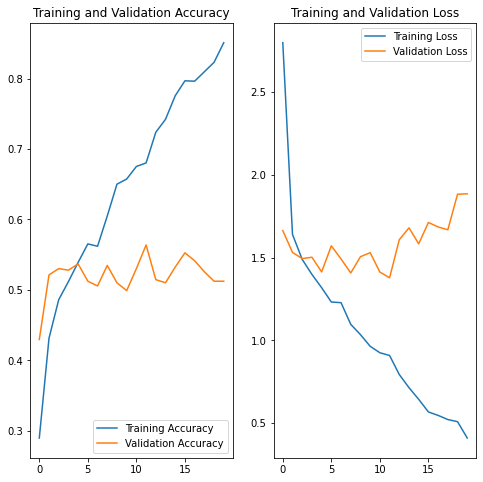

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Findings here


1. Training accuracy is around 85% and Validation accuracy is around 55%
2. There is a gap in validation accurcy. This is bacause of Overfit
3. Lets retrain the model with adding dropouts

### Create the model, compile and train the model


In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
model_update=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
                             
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])


### Compiling the model


In [19]:
model_update.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')




### Training the model


In [20]:
epochs = 20
history = model_update.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 8s 104ms/step - loss: 2.1239 - accuracy: 0.1964 - val_loss: 2.0629 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 5s 92ms/step - loss: 2.0385 - accuracy: 0.1875 - val_loss: 2.0332 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 5s 92ms/step - loss: 2.0307 - accuracy: 0.1920 - val_loss: 2.0350 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0269 - accuracy: 0.2109 - val_loss: 2.0252 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0289 - accuracy: 0.1869 - val_loss: 2.0282 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0287 - accuracy: 0.1914 - val_loss: 2.0308 - val_accuracy: 0.2148
Epoch 7/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0172 - accuracy: 0.2148 - val_loss: 1.9835 - val_accuracy: 0.2841
Epoch 8/20
5

### Visualizing training results

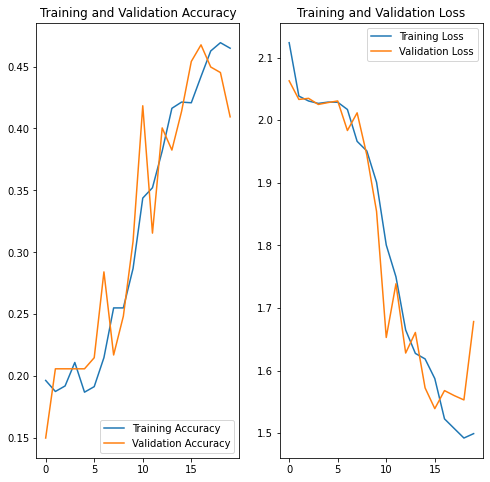

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

Now the training accuracy is 47% and validation accuracy is 45%. So there is no much gap between these two. Will consilder this model as not overfit and its better than the previous model

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Your code goes here.
class_names 
print(class_names)



['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
path_to_training_dataset='/content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB4D0171C50>: 100%|██████████| 500/500 [00:20<00:00, 24.53 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB4D36C6F50>: 100%|██████████| 500/500 [00:21<00:00, 23.21 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB56608CCD0>: 100%|██████████| 500/500 [00:22<00:00, 22.19 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB4D00388D0>: 100%|██████████| 500/500 [01:33<00:00,  5.33 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1007x711 at 0x7FB56608CCD0>: 100%|██████████| 500/500 [01:34<00:00,  5.29 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB4D0112A90>: 100%|██████████| 500/500 [00:17<00:00, 27.84 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB5FB7A5DD0>: 100%|██████████| 500/500 [00:40<00:00, 12.25 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB4D003E910>: 100%|██████████| 500/500 [00:17<00:00, 27.85 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB5FB7A5750>: 100%|██████████| 500/500 [00:18<00:00, 27.49 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [26]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032613.jpg_58ee10b2-2701-44a0-836b-7e53ecd06026.jpg',
 '/content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029177.jpg_e64856d3-f734-469c-9bda-77df891880c8.jpg',
 '/content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027044.jpg_24b81fcd-47f6-433b-81cb-1846eca3f012.jpg',
 '/content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026471.jpg_97ebd5ab-96eb-4262-a861-49a327538a9b.jpg',
 '/content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029248.jpg_81beab4e-65f5-45b8-9a41-726b36974e39.jpg',
 '/content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC

In [27]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new


['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [28]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [29]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [30]:
new_df['Label'].value_counts()

dermatofibroma                500
basal cell carcinoma          500
squamous cell carcinoma       500
nevus                         500
actinic keratosis             500
melanoma                      500
vascular lesion               500
seborrheic keratosis          500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [31]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [44]:
data_dir_train = pathlib.Path("/content/gdrive/My Drive/GoogleCoLab/SkinImagingCollaboration/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [46]:
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [47]:

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [48]:
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [49]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

#### **Todo:**  Train your model

In [50]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
169/169 [==============================] - 34s 192ms/step - loss: 2.6276 - accuracy: 0.2064 - val_loss: 1.8375 - val_accuracy: 0.3541
Epoch 2/30
169/169 [==============================] - 32s 183ms/step - loss: 1.6285 - accuracy: 0.3833 - val_loss: 1.6209 - val_accuracy: 0.4224
Epoch 3/30
169/169 [==============================] - 32s 182ms/step - loss: 1.4146 - accuracy: 0.4687 - val_loss: 1.3186 - val_accuracy: 0.5226
Epoch 4/30
169/169 [==============================] - 32s 183ms/step - loss: 1.2425 - accuracy: 0.5401 - val_loss: 1.2076 - val_accuracy: 0.5419
Epoch 5/30
169/169 [==============================] - 32s 181ms/step - loss: 1.0940 - accuracy: 0.5924 - val_loss: 1.0823 - val_accuracy: 0.6021
Epoch 6/30
169/169 [==============================] - 32s 182ms/step - loss: 1.0003 - accuracy: 0.6376 - val_loss: 1.0325 - val_accuracy: 0.6422
Epoch 7/30
169/169 [==============================] - 32s 185ms/step - loss: 0.8650 - accuracy: 0.6864 - val_loss: 0.9731 - val_ac

#### **Todo:**  Visualize the model results

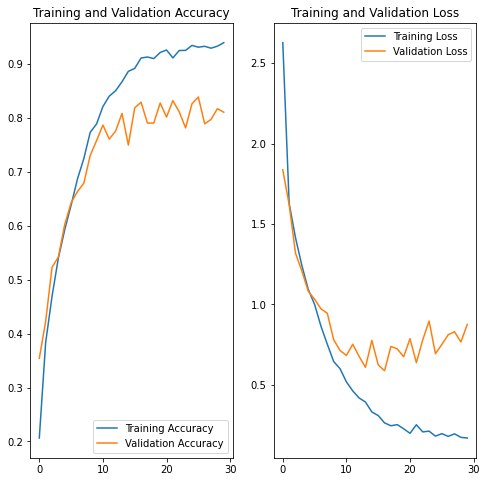

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Training accuracy is around 90% and  Validation Accuracy is around 80%. Since there is no much gap between Training and validation accuracy, there is no oveerfit. 

Augmentation and more epochs helped in removing the overfit to some extent. 

